In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Propogate Divergence & Waist Rays of Gaussian Beamlets - NONastigmatic beamlets

# System Parameters
wl     = 0.6328e-6 # wavelength
d      = .4        # propagation distance
f      = .4      # focal length
n      = 1         # refractive index (add support later)
sample = 256       # number of detector pixels across
amax   = 4e-3      # maximum aperture radius
amin   = 1e-3      # minimum aperture radius

# Configure system matrix - one grid of waist rays, one grid of divergence rays?
OF = 1.5  # overlap factor
W  = amax # width of grid
N  = 3   # number of beams zacross the grid

# Preliminary calculations
gs = (W/N)*OF         # grid spacing, also the beam waist @origin
wo = gs               # beam waist = grid spacing
Zr = (np.pi*wo**2)/wl # Rayleigh range

print(amax**2 / (d*wl),'Fresnel Number')
print(wo)

63.211125158027805 Fresnel Number
0.002


In [146]:
# Configure system ABCD Matrix -> these become optical elements in future revisions
focus = np.array([[1,0],
                  [-1/f,1]])

propg = np.array([[1,d],
                  [0,1]])

# Calculate system ABCD Matrix
system = np.matmul(propg,focus) # CHECK PROPER MULTIPLICATION ORDER

# Define waist ray - unit height, no anlge
waist = np.array([[1]
                 ,[0]]) # top element is y, bottom element is w

# Define divergence ray - unit height, divergence angle!**********************************SHOULD IT HAVE HEIGHT?
divge = np.array([[1],
                  [wl/(np.pi*n*wo)]]) # this is a ray SLOPE, tan(angle)

# Predefine empty array for ray distribution
x = np.linspace(-W,W,N)
y = np.linspace(-W,W,N)
x,y = np.meshgrid(x,y)

# Calculate distance from origin
r = np.sqrt(np.square(x)+np.square(y))

# Create some empty boxes to throw our waist * divergence vectors into
pw = np.zeros([N,N],dtype=object)
pd = np.zeros([N,N],dtype=object)

In [147]:
# Create array of waist rays
for ijk in range(N):
    for lmn in range(N):
        pw[ijk,lmn] = waist*(r[ijk,lmn]+wo) # creates the waist ray, try eliminating wo?****************************************

# Create array of divergence rays
for abc in range(N):
    for xyz in range(N):
        scale = np.array([[r[abc,xyz],0],[0,1]])
        pd[abc,xyz] = np.matmul(scale,divge)
        
# Create some empty boxes to throw vectors into - but this time in ~image space
imgw = np.zeros([N,N],dtype=object)
imgd = np.zeros([N,N],dtype=object)


# Propagate Waist Rays
for wxind in range(N):
    for wyind in range(N):
        imgw[wxind,wyind] = np.matmul(system,pw[wxind,wyind])
        
# Propagate Divergence Rays
for dxind in range(N):
    for dyind in range(N):
        imgd[dxind,dyind] = np.matmul(system,pd[dxind,dyind])

In [148]:
# Great so we've propagated a couple of rays for a couple of points, now turn them into gaussian beams pls!
# Calculate resultant beam waists
wp = np.zeros([N,N])
for wpx in range(N):
    for wpy in range(N):
        imgw_pars = imgw[wpx,wpy]
        imgd_pars = imgd[wpx,wpy]
        wp[wpx,wpy] = np.sqrt((imgw_pars[0,0])**2 + (imgd_pars[0,0])**2) # called "radius" by FRED ppls, but i think its waist

# Determine the distance traveled by each ray f a  m  i l y y y
Rbox = np.zeros([N,N])# Store beam radii of curvature
tbox = np.zeros([N,N])# store propagation distance of each beamlet
for tx in range(N):
    for ty in range(N):
        wtpars = imgw[tx,ty]
        wopars = pw[tx,ty]
        tpars = np.sqrt((wopars[0,0]-wtpars[0,0])**2 + d**2)
        tbox[tx,ty] = tpars
        Rbox[tx,ty] = tpars*(1+(((np.pi*wo**2)/wl)/tpars))**2 # calculate radii of curvature

In [149]:
# Now we have a grid of radii and a grid of waist sizes, letsa plot soma beamses
# So you might have accidentally propagated everything with radial symmetry, which is fine for rotationally symmetric optics!
# The only thing is you seem to have lost track of your x & y spacing, recovering these may be difficult
# This could be accomplished, review your rays again! What do thhey look like?
# So they have an x & y index, and a magnitude, and you know the limits - draw it out?
u = np.linspace(-W,W,sample)
v = np.linspace(-W,W,sample)
u,v = np.meshgrid(u,v)
#zuv = np.sqrt(np.square(u)+np.square(v))
afield = np.zeros([sample,sample])

pbox = np.zeros([N,N])

# utilize indicies of each value to re-extract their position in the X-Y plane
for px in range(N):
    for py in range(N):
        imguvw_pars = imgw[px,py]
        #print(imguvw_pars[0,0]-wo)
        if r[px,py] >= amin and r[px,py] < amax:
            th = np.arctan2((py-(N/2)),(px-N/2))
            #print(px,py)
            p = np.square(u-(imguvw_pars[0,0]-wo)*np.cos(th))+np.square(v-(imguvw_pars[0,0]-wo)*np.sin(th)) # How to shift each beamlet?
            realexp = np.exp(-p/(wp[px,py])**2)
            imagexp = np.exp(1j*((2*np.pi*tbox[px,py]/wl) - np.arctan(tbox[px,py]/Zr) + (p*2*np.pi/(2*Rbox[px,py]*wl))))
            amptude = (wo/wp[px,py])
            afield = afield + amptude*realexp*imagexp

C:\Users\Jaren\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


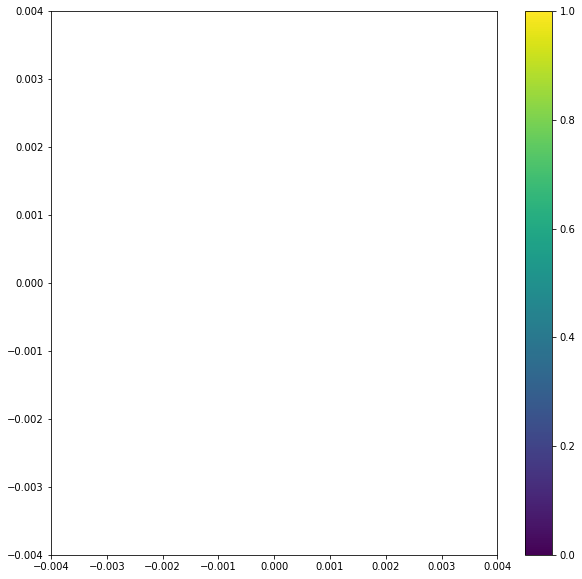

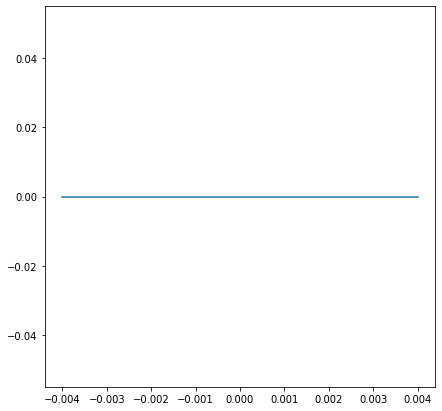

In [150]:
# Just the plot cell
Ifield = (np.real(afield*np.conj(afield)))
plt.figure(figsize=[10,10])
plt.pcolor(u,v,np.log(Ifield))
plt.colorbar()
plt.show()

u = np.linspace(-W,W,sample)

plt.figure(figsize=[7,7])
plt.plot(u,Ifield[128,:])
plt.show()
              

In [65]:
# Test python indexing
a = np.array([[1,2],[3,4]])
for ijk in range(2):
    for abc in range(2):
        print(a[ijk,abc],ijk,abc)

1 0 0
2 0 1
3 1 0
4 1 1


In [80]:
print(N)

2
